# Cross Validation

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['figure.figsize'] = (10, 5)

---
## Load diabetes standardized data set.

In [4]:
from sklearn import datasets
import pandas as pd

diabetes = datasets.load_diabetes()

X = diabetes.data
y = diabetes.target

# center y so we don't need to use a y-intercept in our model
y -= y.mean()
# standardize y to unit variance
y /= y.std()

features = "age sex bmi map tc ldl hdl tch ltg glu".split()
df = pd.DataFrame(X, columns=features)
df

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


---
## Lets fit our data to a Ridge model using 10-fold cross validation

## First, let's split our data into train/test sets...

## We'll perform the cross validation on the training set and use the test set to evaluate the error of the optimized model...

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((353, 10), (89, 10), (353,), (89,))

## Recall that the error to be minimized $= SSE + \alpha \sum_j \beta_j^2$

## Our first goal is to decide what value to use for the hyperparameter $\alpha$

## To do that we will use 10-fold cross validation on the training set...

## And we'll repeat this for a bunch of $\alpha$ values, then choose the one with the lowest validation error...

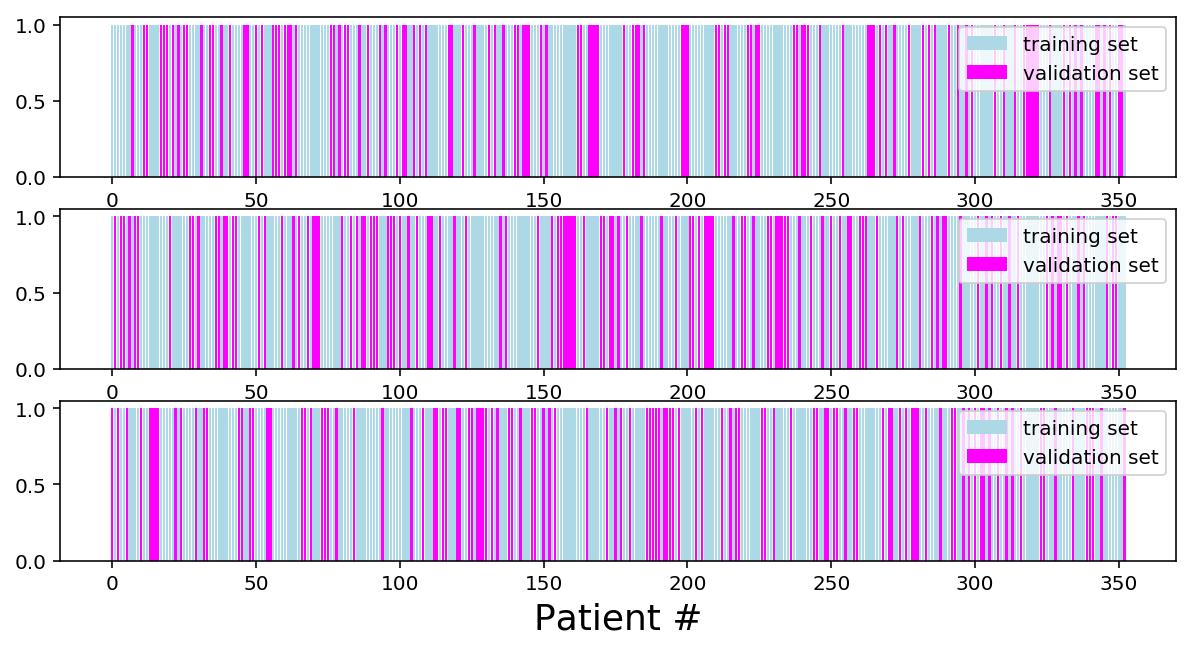

In [28]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True)

k = 1
for train_index, val_index in kf.split(X_train, y_train):
    plt.subplot(3, 1, k)
    plt.bar(train_index, np.ones(train_index.shape), color='lightblue', label='training set')
    plt.bar(val_index, np.ones(val_index.shape), color='magenta', label='validation set')
    plt.xlabel('Patient #')
    plt.legend()
    k += 1

## !!! See what happens when we use shuffling in the above splits

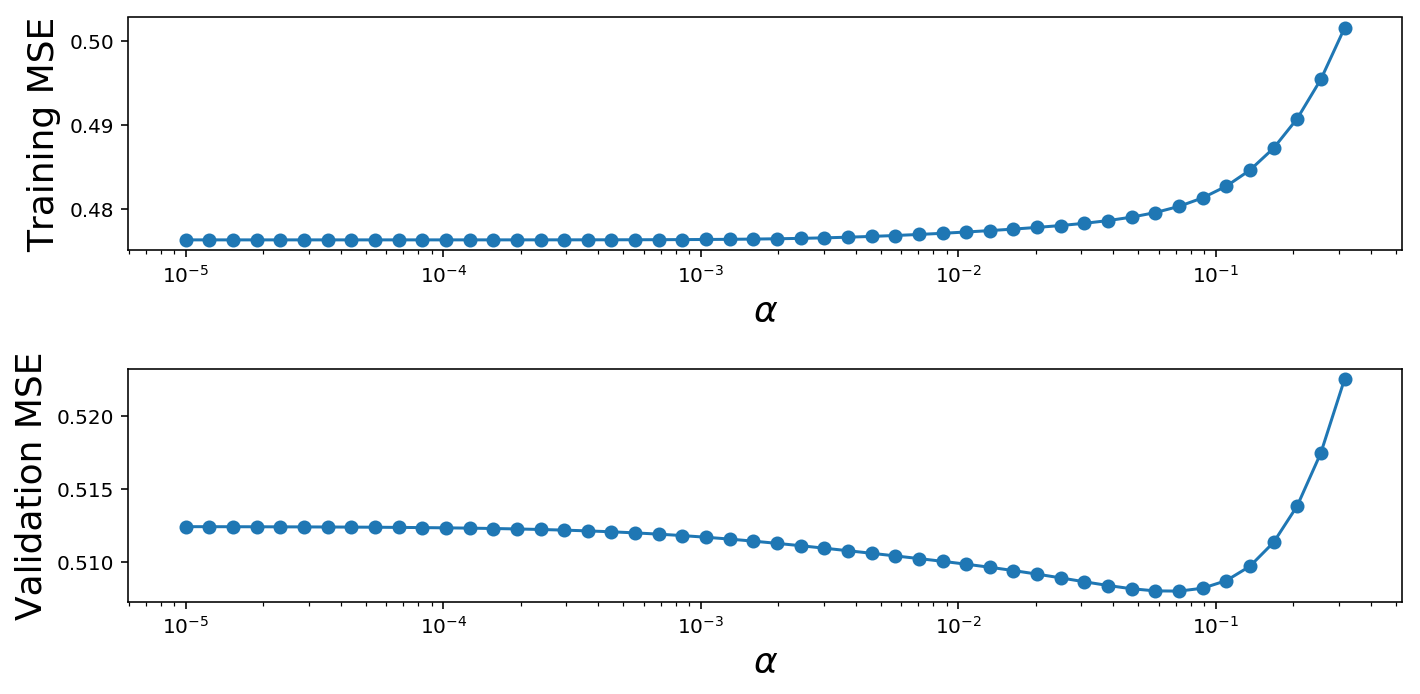

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42)

alphas = np.logspace(-5, -0.5, 50)
mse_train = np.zeros(alphas.shape)
mse_val = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    # Perform 10-fold CV for each alpha and store the resulting average MSE for each of the 10 training and validation sets.
    mse_train_k = []
    mse_val_k = []
    for train_rows, val_rows in kf.split(X_train, y_train):
        # split data into training and validation sets
        X_train_k = X_train[train_rows, :]
        X_val_k = X_train[val_rows, :]
        y_train_k = y_train[train_rows]
        y_val_k = y_train[val_rows]
        
        # new model for each split
        model = Ridge(alpha=alpha)
        
        # fit model to training set
        model.fit(X_train_k, y_train_k)
        
        # get error from training set
        y_train_k_fit = model.predict(X_train_k)
        mse = np.mean((y_train_k - y_train_k_fit)**2)
        mse_train_k.append(mse)
        
        # get error from validation set
        y_val_k_fit = model.predict(X_val_k)
        mse = np.mean((y_val_k - y_val_k_fit)**2)
        mse_val_k.append(mse)
    
    # for each alpha, we take the mean error across all K-folds
    mse_train[i] = np.mean(mse_train_k)
    mse_val[i] = np.mean(mse_val_k)

plt.subplot(211)
plt.plot(alphas, mse_train, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel('Training MSE');
plt.semilogx();

plt.subplot(212)
plt.plot(alphas, mse_val, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel('Validation MSE');
plt.semilogx();

plt.tight_layout();

In [21]:
best_alpha = alphas[np.argmin(mse_val)]
best_alpha

0.07196856730011521

## Now that we know what $\alpha$ to use, we can fit all of our training data...

In [22]:
ridge_model = Ridge(alpha=best_alpha, fit_intercept=False)
ridge_model.fit(X_train, y_train)

Ridge(alpha=0.07196856730011521, copy_X=True, fit_intercept=False,
      max_iter=None, normalize=False, random_state=None, solver='auto',
      tol=0.001)

## And evaluate the error on the test set that has NEVER BEEN USED TO TRAIN THE MODEL!

In [23]:
y_test_fit = ridge_model.predict(X_test)
mse = np.mean((y_test - y_test_fit)**2)
mse

0.5092014852381123

---
## K-fold cross validation wrapped up nice and neat for you.

In [60]:
from sklearn.model_selection import cross_validate

alphas = np.logspace(-5, -0.5, 50)
mse_train = np.zeros(alphas.shape)
mse_val = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    results = cross_validate(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
    mse_train[i] = -results['train_score'].mean()
    mse_val[i] = -results['test_score'].mean()

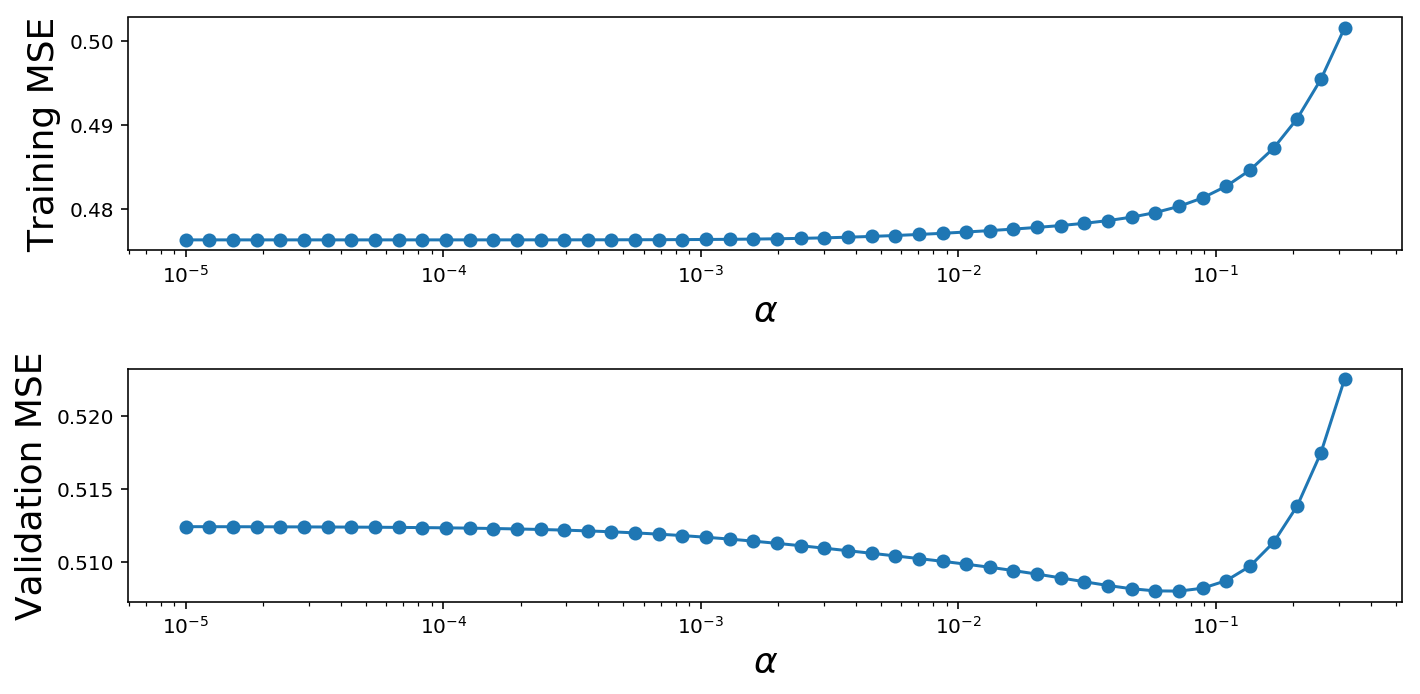

In [24]:
plt.subplot(211)
plt.plot(alphas, mse_train, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel('Training MSE');
plt.semilogx();

plt.subplot(212)
plt.plot(alphas, mse_val, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel('Validation MSE');
plt.semilogx();

plt.tight_layout();

In [26]:
best_alpha = alphas[np.argmin(mse_val)]
best_alpha

0.07196856730011521

---
## More ways to wrap things up nicely for you.

In [27]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': np.logspace(-5, -0.5, 50)}
ridgemodel = Ridge()
cvmodel = GridSearchCV(ridgemodel, params, cv=10, scoring='neg_mean_squared_error')
cvmodel.fit(X_train, y_train)
cvmodel.best_params_['alpha']

0.07196856730011521